In [1]:
import os 
import cv2
import sys
import json
sys.path.append('..')

import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt

from vehicle_nowcasting.data import data_loader, utils, generate_anchors

%matplotlib inline
%load_ext autoreload
%autoreload 2

In [2]:
main_dir = '..'
data_dir = os.path.join(main_dir, 'data')
metadata = pd.read_csv('../data/metadata.csv')
label_map = json.load(open('../data/label_map.json', 'r'))

In [3]:
sources = data_loader.build_source_from_metadata(metadata,
                                                 label_map,
                                                 data_dir)

In [4]:
sources[:2]

[('../data/train/15-02-15-20:17.jpg',
  [(1, 225, 117, 411, 281),
   (3, 335, 212, 456, 329),
   (3, 555, 140, 607, 210),
   (4, 470, 211, 553, 307),
   (4, 442, 138, 519, 202),
   (4, 24, 238, 147, 334),
   (4, 166, 176, 244, 258),
   (4, 388, 110, 435, 167),
   (4, 505, 96, 557, 149),
   (1, 436, 39, 528, 126),
   (3, 546, 66, 593, 106),
   (3, 615, 59, 663, 99)]),
 ('../data/train/33.09-14-17:43.jpg',
  [(3, 378, 288, 579, 474),
   (3, 271, 7, 346, 58),
   (3, 558, 191, 704, 307),
   (3, 555, 132, 695, 214),
   (3, 405, 65, 498, 126),
   (3, 302, 75, 393, 135),
   (3, 227, 32, 293, 72),
   (3, 213, 1, 268, 26),
   (3, 71, 16, 120, 58),
   (2, 8, 39, 101, 155),
   (5, 83, 57, 109, 96),
   (5, 148, 143, 187, 203),
   (5, 150, 108, 191, 161),
   (5, 349, 373, 443, 477),
   (5, 310, 437, 384, 480)])]

In [5]:
vehicle = data_loader.make_dataset(sources, batch_size=32, training=False, hierarchical=False)

W0904 11:25:08.105855 140250170046272 deprecation.py:323] From /home/santiago/anaconda3/envs/CV/lib/python3.6/site-packages/tensorflow_core/python/ops/array_ops.py:1486: where (from tensorflow.python.ops.array_ops) is deprecated and will be removed in a future version.
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


W0904 11:25:09.366264 140250170046272 image.py:648] Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
W0904 11:25:09.399590 140250170046272 image.py:648] Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


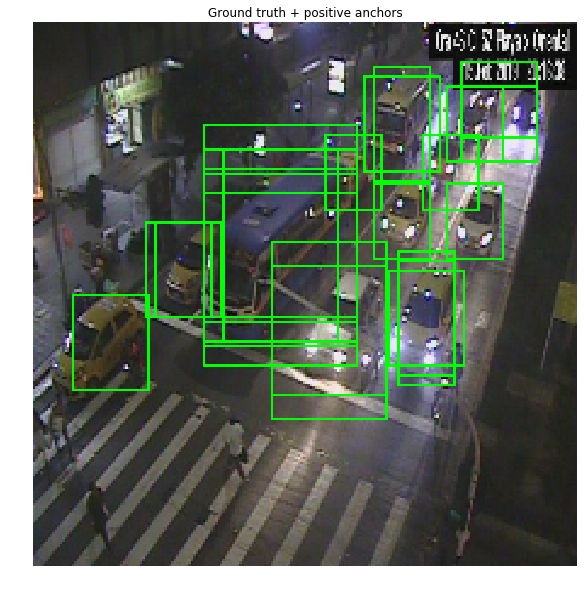

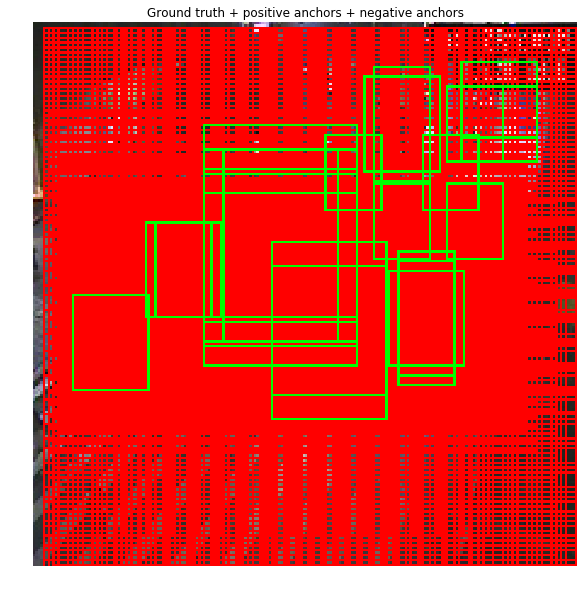

In [6]:
tensor = next(iter(vehicle))
anchors = tensor[1].numpy()
img = tensor[0].numpy()

neg = anchors[anchors[:, -1] == 0]
pos = anchors[anchors[:, -1] == 1]
gt = anchors[anchors[:, -1] == 2]

# img = utils.plot_bb(img, neg, (255, 0, 0), 1)
img = utils.plot_bb(img, pos, (0, 255, 0), 1)
img = utils.plot_bb(img, gt, (0, 0, 255), 2)
plt.figure(figsize=(10, 10))
plt.title('Ground truth + positive anchors')
plt.imshow(img)
plt.axis('off')

img = utils.plot_bb(img, neg, (255, 0, 0), 1)
img = utils.plot_bb(img, pos, (0, 255, 0), 1)
img = utils.plot_bb(img, gt, (0, 0, 255), 2)
plt.figure(figsize=(10, 10))
plt.title('Ground truth + positive anchors + negative anchors')
plt.imshow(img)
plt.axis('off');

In [7]:
vehicle = data_loader.make_dataset(sources, batch_size=32, training=False, hierarchical=True)

W0904 11:25:26.343201 140250170046272 image.py:648] Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


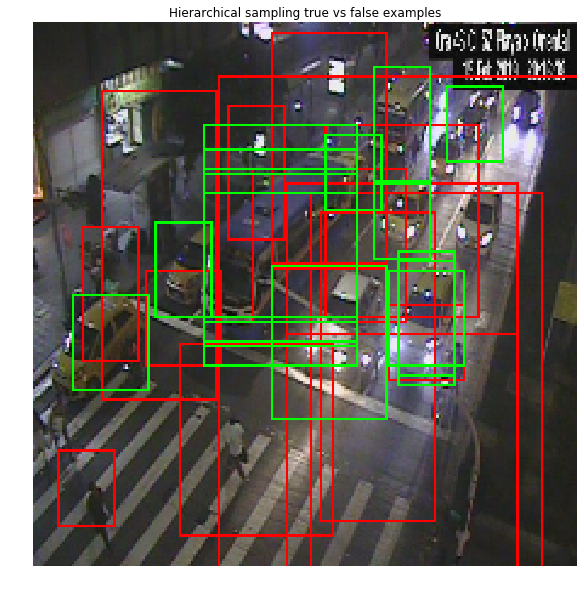

In [8]:
tensor = next(iter(vehicle))
anchors = tensor[1].numpy()
img = tensor[0].numpy()[0, :, :]

neg = anchors[anchors[:, -1] == 0]
pos = anchors[anchors[:, -1] == 1]

img = utils.plot_bb(img, neg, (255, 0, 0), 1)
img = utils.plot_bb(img, pos, (0, 255, 0), 1)

plt.figure(figsize = (10,10))
plt.imshow(img)
plt.axis('off')
plt.title('Hierarchical sampling true vs false examples');